# Recursive prediction with the test/forecast labels missing (multiple step ahead prediction)

In [4]:
# LSTM for international airline passengers problem with regression framing
%matplotlib inline
from __future__ import division
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import copy

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):  # this is how many data points you can construct 
        dataX.append(dataset[i:(i+look_back), :])    #one training data = start : start + lookback 
        dataY.append(dataset[i + look_back, -1])     #one test     data = start + lookback 
    return numpy.array(dataX), numpy.array(dataY)

# gets a vector and turns it into shape a single vector by stacking the columns ot top of each other.  
def modelShaper(x):
    L = []
    modelRecordShape = reduce(lambda w, y: w * y, x[0].shape)  # product of shape gives you the number of elements in x
    for i,record in enumerate(x):
        newRecord = numpy.reshape(record,(1,modelRecordShape)) # create a flat vector 
        if i == 0:
            L = newRecord
        else:
            L = numpy.vstack((L,newRecord))  # stack it on top of the older one !
            
    return numpy.reshape(L,(L.shape[0],L.shape[1],1))  # since it is a flat vector the last dimension is always 0 


def recordJammer(oldRecords,futureRecord,newPrediction):
    # in old records find the last record. The record is made of 1 to n vectors of m elements stacked on top of each other
    # shift each n vector 1 up, so the first vectors is thrown away (too old) while the last one replaces n-1 th one
    # new we are going to replace the last vector (vector n) with a new coming vector. It contains X's of the current time-step
    # and the Y- is the prediction made at time t. 
    lastOldRecord = copy.deepcopy(oldRecords[-1]) # get the last record in the old data
    i = 0 
    while i < len(lastOldRecord)-1: # sliding every record one level up until the last record 
            lastOldRecord[i] = lastOldRecord[i+1] 
            i += 1
    futureRecord[-1] = copy.deepcopy(newPrediction)  # the new prediction (Y(t)) replaces the last element of future record
    lastOldRecord[-1] = futureRecord
    lastOldRecord = numpy.reshape(lastOldRecord,(1,lastOldRecord.shape[0],lastOldRecord.shape[1]))
    return numpy.vstack((oldRecords,lastOldRecord))

# creates a 1-hot-vector of months 
def monthHotVector(x):
    months = range(1,13)
    return [1 if x == i else 0 for i in months]


Using TensorFlow backend.


Graph representing function modelShaper


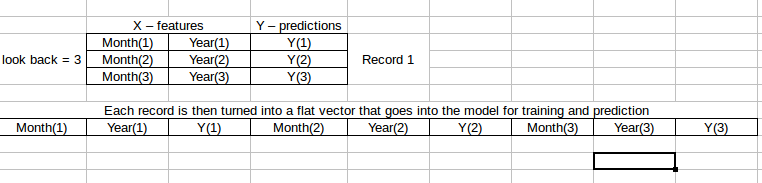

In [5]:
print("Graph representing function modelShaper")
from IPython.display import Image
Image(filename='RNN1.png')

Graph representing function recordJammer


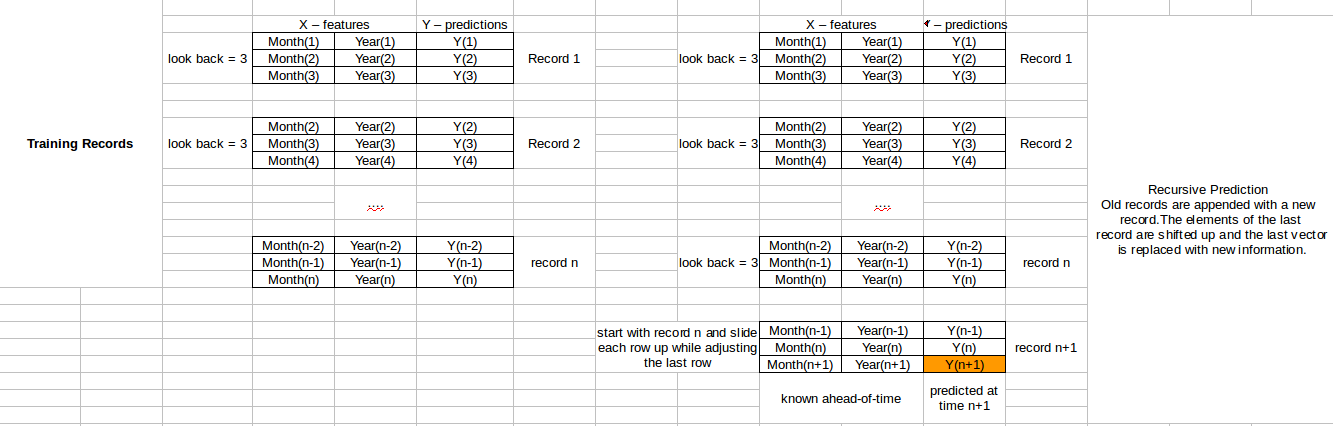

In [6]:
print("Graph representing function recordJammer")
from IPython.display import Image
Image(filename='RNN2.png')

# generating Features

In [10]:

numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[0,1], engine='python', skipfooter=3)
dataset = dataframe.values
import datetime as dt
# dataset = numpy.array([ [(dt.datetime.strptime(str(i[0]),'%Y-%m').month-6)/12,(dt.datetime.strptime(str(i[0]),'%Y-%m').year-1949)/10,i[1]] for i in dataset])
# dataset = numpy.array([ [(dt.datetime.strptime(str(i[0]),'%Y-%m').month-0)/1,(dt.datetime.strptime(str(i[0]),'%Y-%m').year-0)/1,i[1]] for i in dataset])
dataset = numpy.array( [ monthHotVector(dt.datetime.strptime(str(i[0]),'%Y-%m').month) + [dt.datetime.strptime(str(i[0]),'%Y-%m').year] + [i[1]] for i in dataset])

dataset2 = copy.deepcopy(dataset)
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))
# the response variable is rescaled 
dataset[:,-1] = scaler.fit_transform(dataset[:,-1])
dataset[:,-2] = scaler2.fit_transform(dataset[:,-2])  # transforming the year factor (1- hot vector matrix is best)
# dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
# # data splitted into train and test , train data is older than test data
train, test = copy.deepcopy(dataset[0:train_size,:]), copy.deepcopy(dataset[train_size:len(dataset),:])
# # reshape into X=t and Y=t+1
look_back = 3
# # trainX.shape = (94,look_back)
# # trainY.shape = (94)
trainX, trainY = create_dataset(copy.deepcopy(train), look_back)
testX, testY = create_dataset(copy.deepcopy(test), look_back)

# # reshape input to be [samples, time steps, features]
# print(trainX.shape) = (93, 1, 2)
# print(testX.shape) = (45, 1, 2)
# thing about the dimension as follows
# dimension 1: number of samples
# dimension 2: how many features does each sample have ?
# dimension 3: the dimension of each feature
# so what you have is a tensor in 3D = [sampleSize,[dimension of each sample = heightxwidth of each sample]]
# think of height as time-interval of input feature, and width as number of features within each input. 
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], trainX.shape[1], testX.shape[2]))


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

# fitting a model 

In [11]:

# ###################### model block #####################
## create and fit the LSTM network
model = Sequential()
# # i am not sure how this one looks like 
# model.add(LSTM(4, input_shape=(trainX.shape[1], testX.shape[2]),return_sequences=True))
model.add(LSTM(16, input_shape=(modelShaper(trainX)[-1].shape[0], modelShaper(trainX)[-1].shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(modelShaper(trainX), trainY, nb_epoch=100, batch_size=10, verbose=0)


# model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
# model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))

# model graphing

In [12]:
# run below in command line 
# run sudo apt-get update
# sudo apt-get install graphviz   # run this in command line !
# then !pip install pydot-ng
from keras.utils.visualize_util import plot
plot(model, to_file='model.png', show_shapes = True,show_layer_names = True )
from IPython.display import Image
print(model.summary())
Image(filename='model.png')


# !pip install pydot
# !pip install pydot==1.0.2 --upgrade
# !sudo apt-get install graphviz
# !pip install find_graphviz

ImportError: No module named pydot

# prediction

In [13]:
model.reset_states()
trainPredict = model.predict(modelShaper(trainX))
testPredict2 = list()
for p in range(0,len(test)):
    model.reset_states()
    newPrediction = model.predict(modelShaper(trainX))[-1]
    trainX = recordJammer(copy.deepcopy(trainX),copy.deepcopy(test[p]),newPrediction)
    testPredict2 = numpy.append(testPredict2,newPrediction)
testPredict = list(numpy.reshape(testPredict2,(len(testPredict2),1)))



# Graphing results 

Train Score: 12.98 RMSE
Test Score: 26.65 RMSE


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


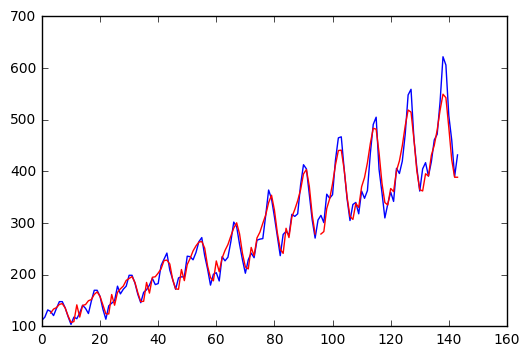

In [14]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([test[:,-1]])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset[:,-1])
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:,0]
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset[:,-1])
testPredictPlot[:] = numpy.nan
testPredictPlot[len(train):len(dataset)] = testPredict[:,0]
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
plt.plot(trainPredictPlot, color = 'red')
plt.plot(testPredictPlot,color = 'red')
plt.show()

# Recursive prediction With the training labels available (one step ahead prediction)

In [38]:
# LSTM for international airline passengers problem with regression framing
%matplotlib inline
from __future__ import division
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):  # this is how many data points you can construct 
        dataX.append(dataset[i:(i+look_back), :])   #one training data = start : start + lookback 
        dataY.append(dataset[i + look_back, -1])     #one test     data = start + lookback 
    return numpy.array(dataX), numpy.array(dataY)

# gets a vector and turns it into shape a single vector by stacking the columns ot top of each other.  
def modelShaper(x):
    L = []
    modelRecordShape = reduce(lambda w, y: w * y, x[0].shape)  # product of shape
    for i,record in enumerate(x):
        newRecord = numpy.reshape(record,(1,modelRecordShape))
        if i == 0:
            L = newRecord
        else:
            L = numpy.vstack((L,newRecord))
            
    return numpy.reshape(L,(L.shape[0],L.shape[1],1))

import copy
def recordJammer(oldRecords,futureRecord,newPrediction):
    # in old records find the last record 
    # this record is going to be update we throw the first element and shift everything up and shove the
    # new record into the last spot 
    lastOldRecord = copy.deepcopy(oldRecords[-1])
    i = 0 
    while i < len(lastOldRecord)-1:# sliding every record one level up until the last record 
            lastOldRecord[i] = lastOldRecord[i+1] 
            i += 1
    futureRecord[-1] = copy.deepcopy(newPrediction)
    lastOldRecord[-1] = futureRecord
    lastOldRecord = numpy.reshape(lastOldRecord,(1,lastOldRecord.shape[0],lastOldRecord.shape[1]))
    return numpy.vstack((oldRecords,lastOldRecord))



# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[0,1], engine='python', skipfooter=3)
dataset = dataframe.values
import datetime as dt
dataset = numpy.array([ [(dt.datetime.strptime(str(i[0]),'%Y-%m').month-6)/12,(dt.datetime.strptime(str(i[0]),'%Y-%m').year-1949)/10,i[1]] for i in dataset])
dataset2 = copy.deepcopy(dataset)
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
# the response variable is rescaled 
dataset[:,(-1)] = scaler.fit_transform(dataset[:,(-1)])
# dataset[:,0:-1] = scaler2.fit_transform(dataset[:,0:-1])
# dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
# # data splitted into train and test , train data is older than test data
train, test = copy.deepcopy(dataset[0:train_size,:]), copy.deepcopy(dataset[train_size:len(dataset),:])
# # reshape into X=t and Y=t+1
look_back = 2
# # trainX.shape = (94,look_back)
# # trainY.shape = (94)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
# print(trainX.shape) = (93, 1, 2)
# print(testX.shape) = (45, 1, 2)
# thing about the dimension as follows
# dimension 1: number of samples
# dimension 2: how many features does each sample have ?
# dimension 3: the dimension of each feature
# so what you have is a tensor in 3D = [sampleSize,[dimension of each sample = heightxwidth of each sample]]
# think of height as time-interval of input feature, and width as number of features within each input. 
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], trainX.shape[1], testX.shape[2]))

###################### model block #####################
# ## create and fit the LSTM network
# model = Sequential()
# # # i am not sure how this one looks like 
# # model.add(LSTM(4, input_shape=(trainX.shape[1], testX.shape[2]),return_sequences=True))
# model.add(LSTM(8, input_shape=(modelShaper(trainX)[-1].shape[0], modelShaper(trainX)[-1].shape[1])))
# # model.add(LSTM(4))
# # model.add(LSTM(8))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(modelShaper(trainX), trainY, nb_epoch=100, batch_size=10, verbose=0)



################## make predictions
model.reset_states()
trainPredict = model.predict(modelShaper(trainX))

testPredict2 = list()
for p in range(0,len(test)):
    model.reset_states()
    newPrediction = model.predict(modelShaper(trainX[-1:]))[-1]
    trainX = recordJammer(copy.deepcopy(trainX),copy.deepcopy(test[p]),copy.deepcopy(test[p][-1]))
    testPredict2 = numpy.append(testPredict2,newPrediction)
testPredict = list(numpy.reshape(testPredict2,(len(testPredict2),1)))

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([test[:,-1]])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset[:,-1])
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:,0]
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset[:,-1])
testPredictPlot[:] = numpy.nan
testPredictPlot[len(train):len(dataset)] = testPredict[:,0]
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
plt.plot(trainPredictPlot, color = 'red')
plt.plot(testPredictPlot,color = 'red')
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Exception: Error when checking : expected lstm_input_7 to have shape (None, 9, 1) but got array with shape (93, 6, 1)

In [ ]:
trainX[-2:]

In [ ]:
test[p][-1]

In [ ]:
dataset[-6:-1,]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
# the response variable is rescaled 
# dataset[:,(-1)] = scaler.fit_transform(dataset[:,(-1)])
dataset = scaler.fit_transform(dataset)

In [ ]:
dir(scaler.inverse_transform)

In [ ]:
scaled_features[col_names].values

In [ ]:
scaler.fit_transform(dataset)

In [ ]:
testPredict.shape

In [ ]:
testY[0].shape

In [ ]:
dataset2[:,-1]

In [ ]:
# LSTM for international airline passengers problem with regression framing
%matplotlib inline
from __future__ import division
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):  # this is how many data points you can construct 
        dataX.append(dataset[i:(i+look_back), :])   #one training data = start : start + lookback 
        dataY.append(dataset[i + look_back, -1])     #one test     data = start + lookback 
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[0,1], engine='python', skipfooter=3)
dataset = dataframe.values
import datetime as dt
dataset = numpy.array([ [dt.datetime.strptime(str(i[0]),'%Y-%m').month/12,(dt.datetime.strptime(str(i[0]),'%Y-%m').year-1949)/10,i[1]] for i in dataset])
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
# the response variable is rescaled 
dataset[:,(-1)] = scaler.fit_transform(dataset[:,(-1)])
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
# # data splitted into train and test , train data is older than test data
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# # reshape into X=t and Y=t+1
look_back =2
# # trainX.shape = (94,look_back)
# # trainY.shape = (94)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # # reshape input to be [samples, time steps, features]
# # print(trainX.shape) = (93, 1, 2)
# # print(testX.shape) = (45, 1, 2)
# # thing about the dimension as follows
# # dimension 1: number of samples
# # dimension 2: how many features does each sample have ?
# # dimension 3: the dimension of each feature
# # so what you have is a tensor in 3D = [sampleSize,[dimension of each sample = heightxwidth of each sample]]
# think of height as time-interval of input feature, and width as number of features within each input. 
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], trainX.shape[1], testX.shape[2]))

# # # create and fit the LSTM network
# model = Sequential()
# # # i am not sure how this one looks like 
# # model.add(LSTM(4, input_shape=(trainX.shape[1], testX.shape[2]),return_sequences=True))
# model.add(LSTM(4, input_shape=(trainX.shape[1], testX.shape[2])))
# # model.add(LSTM(8))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# # model.fit(trainX, trainY, nb_epoch=100, batch_size=10, verbose=1)
# # make predictions
# trainPredict = model.predict(trainX)
# testPredict = trainX
# testPredict2 = list()
# for p in range(0,len(trainY)):
#     testPredict.append(model.predict(testPredict[-10:-1])[-1])
#     testPredict2.append(testPredict[-1])
# testPredict = testPredict2
# # testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
# # shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
# plt.plot(trainPredictPlot, color = 'red')
# plt.plot(testPredictPlot,color = 'red')
# plt.show()

# Generalizing the code 

In [ ]:
# LSTM for international airline passengers problem with regression framing
%matplotlib inline
from __future__ import division
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):  # this is how many data points you can construct 
        dataX.append(dataset[i:(i+look_back), :])   #one training data = start : start + lookback 
        dataY.append(dataset[i + look_back, -1])     #one test     data = start + lookback 
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[0,1], engine='python', skipfooter=3)
dataset = dataframe.values
import datetime as dt
dataset = numpy.array([ [dt.datetime.strptime(str(i[0]),'%Y-%m').month/12,(dt.datetime.strptime(str(i[0]),'%Y-%m').year-1949)/10,i[1]] for i in dataset])
dataset2 = copy.deepcopy(dataset)
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
# the response variable is rescaled 
dataset[:,(-1)] = scaler.fit_transform(dataset[:,(-1)])
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
# # data splitted into train and test , train data is older than test data
train, test = copy.deepcopy(dataset[0:train_size,:]), copy.deepcopy(dataset[train_size:len(dataset),:])
# # reshape into X=t and Y=t+1
look_back =1
# # trainX.shape = (94,look_back)
# # trainY.shape = (94)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # # reshape input to be [samples, time steps, features]
# # print(trainX.shape) = (93, 1, 2)
# # print(testX.shape) = (45, 1, 2)
# # thing about the dimension as follows
# # dimension 1: number of samples
# # dimension 2: how many features does each sample have ?
# # dimension 3: the dimension of each feature
# # so what you have is a tensor in 3D = [sampleSize,[dimension of each sample = heightxwidth of each sample]]
# think of height as time-interval of input feature, and width as number of features within each input. 
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], trainX.shape[1], testX.shape[2]))


# gets a vector and turns it into shape a single vector by stacking the columns ot top of each other.  
def modelShaper(x):
    L = []
    modelRecordShape = reduce(lambda w, y: w * y, x[0].shape)  # product of shape
    for i,record in enumerate(x):
#         modelRecordShape = reduce(lambda x, y: x * y, record.shape)  # product of shape
        newRecord = numpy.reshape(record,(1,modelRecordShape))
        if i == 0:
            L = newRecord
        else:
            L = numpy.vstack((L,newRecord))
            
    return numpy.reshape(L,(L.shape[0],L.shape[1],1))

import copy
def recordJammer(oldRecords,futureRecord,newPrediction):
    # in old records find the last record 
    # this record is going to be update we throw the first element and shift everything up and shove the
    # new record into the last spot 
    lastOldRecord = copy.deepcopy(oldRecords[-1])
    i = 0 
    while i < len(lastOldRecord)-1:# sliding every record one level up until the last record 
            lastOldRecord[i] = lastOldRecord[i+1] 
            i += 1
    futureRecord[-1] = newPrediction
    lastOldRecord[-1] = futureRecord
    lastOldRecord = numpy.reshape(lastOldRecord,(1,lastOldRecord.shape[0],lastOldRecord.shape[1]))
    return numpy.vstack((oldRecords,lastOldRecord))


# for p in test_size:

    
    
# for i in testX:
#     print(i)
#     print(i.shape[0]*i.shape[1])
#     break

# # # create and fit the LSTM network
model = Sequential()
# # i am not sure how this one looks like 
# model.add(LSTM(4, input_shape=(trainX.shape[1], testX.shape[2]),return_sequences=True))
model.add(LSTM(4, input_shape=(modelShaper(trainX)[-1].shape[0], modelShaper(trainX)[-1].shape[1])))
# model.add(LSTM(4))
# model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(modelShaper(trainX), trainY, nb_epoch=100, batch_size=10, verbose=0)
# make predictions
model.reset_states()
trainPredict = model.predict(modelShaper(trainX))
# testPredict = trainX
# testPredict2 = list()

    
testPredict2 = list()
for p in range(0,len(test)):
#     new = testX[p]
    model.reset_states()
    newPrediction = model.predict(modelShaper(trainX[-10:]))[-1]
    trainX = recordJammer(trainX,test[p],newPrediction)
#     new = numpy.reshape(new,(1,testX[p].shape[0],testX[p].shape[1]))
#     testPredict = numpy.vstack((testPredict,new))
#     testPredict = numpy.reshape(testPredict)
#     break
    testPredict2 = numpy.append(testPredict2,newPrediction)
testPredict = list(numpy.reshape(testPredict2,(len(testPredict2),1)))
# plt.plot(testPredict2)
# for p in range(0,len(trainY)):
#     testPredict.append(model.predict(testPredict[-10:-1])[-1])
#     testPredict2.append(testPredict[-1])
# testPredict = testPredict2
# # testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset[:,-1])
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:,0]
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset[:,-1])
testPredictPlot[:] = numpy.nan
testPredictPlot[len(train):len(dataset)] = testPredict[:,0]
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
plt.plot(trainPredictPlot, color = 'red')
plt.plot(testPredictPlot,color = 'red')
plt.show()

In [ ]:
len(dataset)

In [ ]:
trainPredictPlot = numpy.empty_like(dataset[:,-1])
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:,0]
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset[:,-1])
testPredictPlot[:] = numpy.nan
testPredictPlot[len(train):len(dataset)] = testPredict[:,0]
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
plt.plot(trainPredictPlot, color = 'red')
plt.plot(testPredictPlot,color = 'red')
plt.show()

In [ ]:
plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
plt.show()

In [ ]:
print(scaler.inverse_transform(dataset[:,-1]))
print(trainPredictPlot)
print(testPredictPlot)

In [ ]:
plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
plt.plot(trainPredictPlot, color = 'red')
plt.plot(testPredictPlot,color = 'red')
plt.show()

In [ ]:
testPredictPlot = numpy.empty_like(dataset[:,-1])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
plt.plot(trainPredictPlot, color = 'red')
plt.plot(testPredictPlot,color = 'red')
plt.show()

In [ ]:
plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
plt.plot(trainPredictPlot, color = 'red')
plt.plot(testPredictPlot,color = 'red')
plt.show()

In [ ]:
scaler.inverse_transform(dataset[:,-1])


In [ ]:
testPredictPlot

In [ ]:
plt.plot(dataset[:,-1],color = 'blue')
plt.plot(trainPredictPlot, color = 'red')
plt.plot(testPredictPlot,color = 'red')
plt.show()

In [ ]:
testY 

In [ ]:
testPredict2

In [ ]:
testPredict

In [ ]:
testPredict

In [ ]:
trainY

In [ ]:
trainPredict

In [ ]:
plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
# plt.plot(trainPredictPlot, color = 'red')
# plt.plot(testPredictPlot,color = 'red')
plt.show()

In [ ]:
testPredictPlot[len(train):len(dataset), :] = testPredict

In [ ]:
len(testPredict)

In [ ]:
(len(train)+1) - (len(dataset)-1)

In [ ]:
model.predict(modelShaper(trainX[-10:]))[-1]

In [ ]:
model.predict(trainX[-10:])[-1]

In [ ]:
test[-1]

In [ ]:
Y[-1] = P
numpy.vstack((X,Y))

In [ ]:
import copy
def recordJammer(oldRecords,futureRecord,newPrediction):
    # in old records find the last record 
    # this record is going to be update we throw the first element and shift everything up and shove the
    # new record into the last spot 
    lastOldRecord = copy.deepcopy(oldRecords[-1])
    i = 0 
    while i < len(lastOldRecord)-1:# sliding every record one level up until the last record 
            lastOldRecord[i] = lastOldRecord[i+1] 
            i += 1
    futureRecord[-1] = newPrediction
    lastOldRecord[-1] = futureRecord
    lastOldRecord = numpy.reshape(lastOldRecord,(1,lastOldRecord.shape[0],lastOldRecord.shape[1]))
    return numpy.vstack((oldRecords,lastOldRecord))

    
X = testX[1:4]
Y = dataset[40]
P = dataset[50][-1]


# Y.shape
print(X)
print(Y)
print(P)
# recordJammer(X,Y,P)

In [ ]:
recordJammer(X,Y,P)

In [ ]:
len(X[-1])

In [ ]:
X[-1][-1]

In [ ]:
def modelShaper(x):
    L = []
    modelRecordShape = reduce(lambda w, y: w * y, x[0].shape)  # product of shape
    for i,record in enumerate(x):
#         modelRecordShape = reduce(lambda x, y: x * y, record.shape)  # product of shape
        newRecord = numpy.reshape(record,(1,modelRecordShape))
        if i == 0:
            L = newRecord
        else:
            L = numpy.vstack((L,newRecord))
    return L

In [ ]:
testX[-2]

In [ ]:
for i in testX:
    print(i)
    print(i.shape[0]*i.shape[1])
    break

In [ ]:
testX.shape[0]*testX.shape[1]*testX.shape[2]

In [ ]:
for i in testX:
    print(i)
    print(i.shape[0]*i.shape[1])
    break

# Reshaping input as a vecor

In [ ]:
# LSTM for international airline passengers problem with regression framing
%matplotlib inline
from __future__ import division
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):  # this is how many data points you can construct 
        dataX.append(dataset[i:(i+look_back), :].reshape(1,look_back*3))   #one training data = start : start + lookback 
        dataY.append(dataset[i + look_back, -1])     #one test     data = start + lookback 
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[0,1], engine='python', skipfooter=3)
dataset = dataframe.values
import datetime as dt
dataset2 = numpy.array([[i[0],int(i[1])] for i in dataset])

dataset = numpy.array([ [dt.datetime.strptime(str(i[0]),'%Y-%m').month/12,(dt.datetime.strptime(str(i[0]),'%Y-%m').year-1949)/10,i[1]] for i in dataset])
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
# the response variable is rescaled 
dataset[:,(-1)] = scaler.fit_transform(dataset[:,(-1)])
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
# # data splitted into train and test , train data is older than test data
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# # reshape into X=t and Y=t+1
look_back = 4
# # trainX.shape = (94,look_back)
# # trainY.shape = (94)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
# print(trainX.shape) = (93, 1, 2)
# print(testX.shape) = (45, 1, 2)
# thing about the dimension as follows
# dimension 1: number of samples
# dimension 2: how many features does each sample have ?
# dimension 3: the dimension of each feature
# so what you have is a tensor in 3D = [sampleSize,[dimension of each sample = heightxwidth of each sample]]
# think of height as time-interval of input feature, and width as number of features within each input. 
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], trainX.shape[1], testX.shape[2]))

# # create and fit the LSTM network
model = Sequential()
# # i am not sure how this one looks like 
model.add(LSTM(8, input_shape=(trainX.shape[1], testX.shape[2])))
# model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=5, verbose=0)
# make predictions
trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
testPredict = []
import copy
testPredict = copy.deepcopy(trainX)
testPredict2 = list()
for p in range(0,len(testX)):
    new = testX[p]
    new[-1][-1] = model.predict(testPredict[-10:])[-1]
    new = numpy.reshape(new,(1,testX[p].shape[0],testX[p].shape[1]))
    testPredict = numpy.vstack((testPredict,new))
#     testPredict = numpy.reshape(testPredict)
#     break
    testPredict2 = numpy.append(testPredict2,testPredict[-1][-1][-1])
testPredict = list(numpy.reshape(testPredict2,(len(testPredict2),1)))
#     # print(testPredict)    

# # invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset2)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, 1] = trainPredict[:,0]
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset2)
testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict)+look_back:len(trainPredict)+look_back+len(testPredict),1 ] = testPredict[:,0]
testPredictPlot[-1*len(testPredict):,1 ] = testPredict[:,0]
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[:,-1]),color = 'blue')
plt.plot(trainPredictPlot, color = 'red')
plt.plot(testPredictPlot,color = 'red')
plt.show()

In [ ]:
model.summary()

In [ ]:
!pip install pydot

# New Model
We can also phrase the problem so that multiple recent time steps can be used to make the prediction for the next time step.

This is called a window and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t) as well as the two prior times (t-1 and t-2) as input variables.

When phrased as a regression problem the input variables are t-2, t-1, t and the output variable is t+1.

In [ ]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_dim=look_back))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose = 0)
# # make predictions
# trainPredict = model.predict(trainX)
# # testPredict = model.predict(testX)
# import copy
# testPredict = copy.deepcopy(trainX)
# testPredict2 = list()
# for p in range(0,len(testX)):
#     testPredict = numpy.append(testPredict,numpy.reshape(model.predict(testPredict[-10:])[-1],(1,1)))
#     testPredict = numpy.reshape(testPredict,(len(testPredict),1,1))
#     testPredict2 = numpy.append(testPredict2,testPredict[-1])
# #     print(model.predict(testPredict[:])[-1])
# testPredict = list(numpy.reshape(testPredict2,(len(testPredict2),1)))
# # plt.plot(testPredict)
# # # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# # plt.plot(testPredict)
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
# # shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

In [ ]:
testX[-1]

# New Model 
You may have noticed that the data preparation for the LSTM network includes time steps.

Some sequence problems may have a varied number of time steps per sample. For example, you may have measurements of a physical machine leading up to a point of failure or a point of surge. Each incident would be a sample, the observations that lead up to the event would be the time steps and the variables observed would be the features.

Time steps provide another way to phrase our time series problem. Like above in the window example, we can take prior time steps in our time series as inputs to predict the output at the next time step.

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.



In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_dim=1))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
# # make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
# # shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

In [ ]:
testX[-1]

# New Model
The LSTM network has memory which is capable of remembering across long sequences.

Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate().

We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful”. This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions.

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states(), for example:

so here your epoch is 1 instead of 100 and your reset the state at the end of each loop over the training data 
previouslty epoch was 100 ... and based on the statement above the state was reset after each batch ... i do not know what prevents it from happening here
    for i in range(100):
        model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()

Finally, when the LSTM layer is constructed, the stateful parameter must be set True and instead of specifying the input dimensions, we must hard code the number of samples in a batch, number of time steps in a sample and number of features in a time step by setting the batch_input_shape parameter. For example:

i think by stateful = True , the model does not reset the state at the end of each batch training. It will reset it only when told so by model.reset_states() which happens at the end of epoch (one loop over the training data)
    model.add(LSTM(4, batch_input_shape=(batch_size, time_steps, features), stateful=True))

This same batch size must then be used later when evaluating the model and making predictions. For example:

    model.predict(trainX, batch_size=batch_size)

We can adapt the previous time step example to use a stateful LSTM. The full code listing is provided below.

In [ ]:
# LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
# batch_size = 1
# model = Sequential()
# model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# for i in range(100):
# 	model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
# 	model.reset_states()
# # make predictions
# trainPredict = model.predict(trainX, batch_size=batch_size)
# model.reset_states()
# testPredict = model.predict(testX, batch_size=batch_size)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
# # shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

In [ ]:
testX[-1]

# Stacked LSTMs With Memory Between Batches

Finally, we will take a look at one of the big benefits of LSTMs, the fact that they can be successfully trained when stacked into deep network architectures.

LSTM networks can be stacked in Keras in the same way that other layer types can be stacked. One addition to the configuration that is required is that an LSTM layer prior to each subsequent LSTM layer must return the sequence. This can be done by setting the return_sequences parameter on the layer to True.

We can extend the stateful LSTM in the previous section to have two layers, as follows:


    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))

The entire code listing is provided below for completeness.



In [ ]:
# Stacked LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [3]:
!pip install pip
!pip install pandas
!pip install keras
!pip install sklearn
# !pip install pydot

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:318: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from c

In [6]:
!pip install pip

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas